In [1]:
import os 
os.chdir('../')
from PIL import Image 
from arguments import parser 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 
from main import torch_seed
from collections import OrderedDict

torch_seed(42)
exp_dir = '/Volume/VAD/LifeLongerAD_cu121/results/CFGCAD/MVTecAD/baseline6_200epoch-3_5_with_5_step-Continual_True-online_False/seed_42/'
cfg_dir = os.path.join(exp_dir,'configs.yaml')
cfg = OmegaConf.load(cfg_dir)


model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        ).to('cuda')
device = 'cuda'


loader_dict = {}
accelerator = Accelerator()
for cn in cfg.DATASET.class_names:
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cn,
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = True 
    )    

    testloader = DataLoader(
            dataset     = testset,
            batch_size  = 2,
            num_workers = cfg.DATASET.num_workers,
            shuffle     = False 
        )    
    
    loader_dict[cn] = {'train':trainloader,'test':testloader}    


In [2]:
def test(model, dataloader, device):
    from utils.metrics import MetricCalculator, loco_auroc    
    model.eval()
    img_level = MetricCalculator(metric_list = ['auroc','average_precision'])
    pix_level = MetricCalculator(metric_list = ['auroc','average_precision'])     
    
    #! Inference     
    for idx, (images, labels, class_labels, gts) in enumerate(dataloader):

        with torch.no_grad():
            Input = {'image':images,'clsname':class_labels}
            outputs = model(Input)   
            score_map = outputs['pred'].detach().cpu()            
            score = score_map.reshape(score_map.shape[0],-1).max(-1)[0]
                
        # Stack Scoring for metrics 
        pix_level.update(score_map,gts.type(torch.int))
        img_level.update(score, labels.type(torch.int))
        

            
    i_results, p_results = img_level.compute(), pix_level.compute()    
        
    test_result = OrderedDict(img_level = i_results)
    test_result.update([('pix_level', p_results)])
    
    return test_result 

In [3]:
cn = cfg.DATASET.class_names[0]
test_loader = loader_dict[cn]['test']

model_weight = os.path.join(exp_dir,'model_weight',f'{cn}_model.pth')
weight = torch.load(model_weight)
model.load_state_dict(weight)    
model = model.cuda()

In [4]:
temp = [] 
for gs in [0,2,4,16,32,64,128,256,512]:
    
    model.reconstruction.guidance_scale = gs 
    
    test_result = test(model, test_loader,'cuda')
    
    temp.append([test_result['img_level']['auroc'],
                 test_result['pix_level']['auroc']])

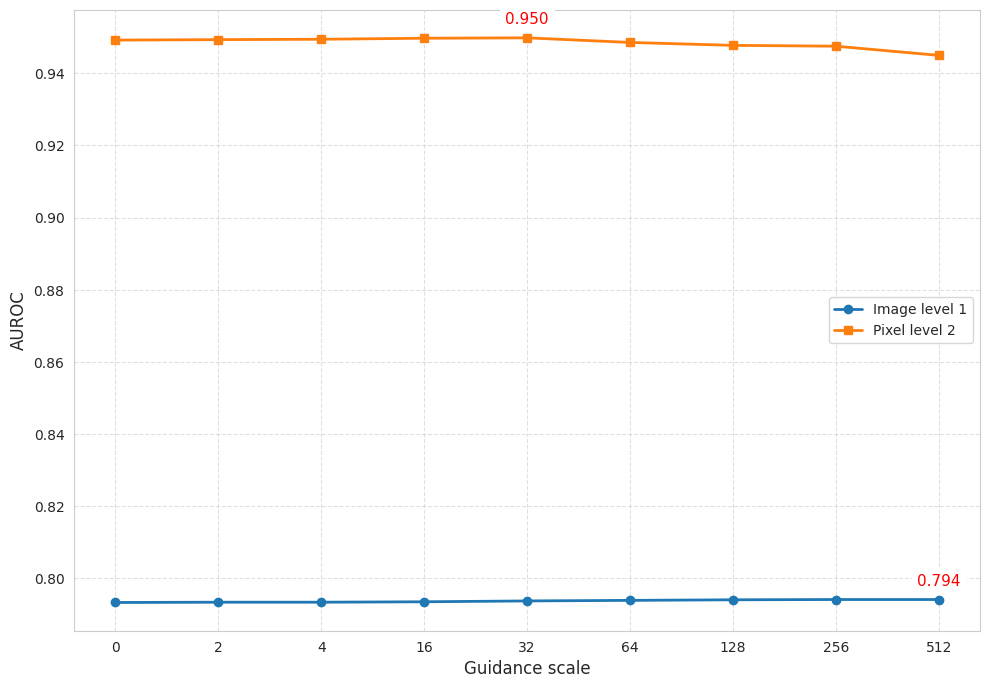

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 예시 데이터
temp = np.array(temp)
gs_list = np.array([0, 2, 4, 16, 32, 64, 128, 256, 512])

# x축은 0,1,2...8
x_idx = np.arange(len(gs_list))

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

# 두 개의 시리즈 그리기
ax.plot(x_idx, temp[:, 0], marker='o', linewidth=2, label='Image level 1')
ax.plot(x_idx, temp[:, 1], marker='s', linewidth=2, label='Pixel level 2')

# 최대값 강조＋레벨 표시 (5포인트 위로 오프셋)
for series in [temp[:,0], temp[:,1]]:
    idx_max = np.argmax(series)
    x, y = x_idx[idx_max], series[idx_max]
    # ax.scatter(x, y, s=150, facecolors='none', edgecolors='red', linewidths=2, zorder=5)
    ax.annotate(f'{y:.3f}',
                xy=(x, y),
                xytext=(0, 8),            # (x, y) 위치에서 위로 5pt 올림
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=11,
                color='red',
                backgroundcolor='white')

# x축 눈금과 레이블
ax.set_xticks(x_idx)
ax.set_xticklabels(gs_list)

# 라벨, 범례, 격자
ax.set_xlabel('Guidance scale', fontsize=12)
ax.set_ylabel('AUROC', fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# Anomaly Score

In [ ]:
def test(model, dataloader, device):
    from utils.metrics import MetricCalculator, loco_auroc    
    model.eval()
    img_level = MetricCalculator(metric_list = ['auroc','average_precision'])
    pix_level = MetricCalculator(metric_list = ['auroc','average_precision'])     
    
    #! Inference     
    for idx, (images, labels, class_labels, gts) in enumerate(dataloader):

        with torch.no_grad():
            Input = {'image':images,'clsname':class_labels}
            outputs = model(Input)   
            score_map = outputs['pred'].detach().cpu()            
            score = score_map.reshape(score_map.shape[0],-1).max(-1)[0]
                
        # Stack Scoring for metrics 
        pix_level.update(score_map,gts.type(torch.int))
        img_level.update(score, labels.type(torch.int))
        

            
    i_results, p_results = img_level.compute(), pix_level.compute()    
        
    test_result = OrderedDict(img_level = i_results)
    test_result.update([('pix_level', p_results)])
    
    return img_level, pix_level 